In [1]:
%load_ext autoreload
%autoreload 2

from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yaml

from dataset.june_dataset import JuNEDataset
from metrics.metrics_time import TimeMetrics


def read_config(config_path: Path = Path("data_config.yaml")) -> dict:
    with config_path.open("r") as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError:
            return {}


config = read_config()


In [2]:
df_hack = pd.read_csv(config.get("dataset_path"), index_col=0)
df_labels = pd.read_csv(config.get("label_mapping_path"), index_col=0)
df_hack = df_hack.merge(df_labels, on='action_id')

df_hack.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,NaN,NaN,NaN,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",NaN,student_7,False,NaN
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions


In [3]:
june = JuNEDataset(df_hack)
june.prepare_dataset()
june.df.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label,task
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",None,student_7,False,,task1
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,helper_functions,task1
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,helper_functions,task1
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1


In [5]:
TM = TimeMetrics()
metrics = TM.calculate_metrics(june.df)
metrics.head()
kernel_mapping  = metrics.loc[:, ['kernel_id', 'task', 'expert']].drop_duplicates()


# Action time

In [7]:
metrics.groupby(['task', 'expert']).next_action_time.describe()


count       mean         std    min      25%    50%       75%  \
task  expert                                                                   
task1 False   5718.0  42.983284  309.940488  0.000  1.46950  7.725  26.78825   
      True    1548.0  31.697414   73.155112  0.000  2.48525  9.797  33.18100   
task2 False   1717.0  42.879314  323.199584  0.001  1.65900  5.711  19.66900   
      True    2853.0  27.812308  155.382600  0.000  0.74900  3.917  14.14500   

                    max  
task  expert             
task1 False   12649.736  
      True     1426.984  
task2 False    9607.840  
      True     4114.957

In [8]:
test  = metrics.groupby(['task', 'expert']).describe()


In [9]:
tr = metrics.next_action_time.quantile(.95)
# TODO recalculate execute time
at_df = metrics.loc[(metrics.next_action_time < tr), :]


In [10]:
cols = list(product(['execution_time_sec', 'next_action_time'],['mean', 'std']))
desc_stats_all = at_df.groupby(['task', 'expert']).describe().loc[:,cols]
desc_stats_exp = at_df.groupby(['expert']).describe().loc[:,cols]
desc_stats_task = at_df.groupby(['task']).describe().loc[:,cols]


In [11]:
pg.anova(data=at_df, dv= 'next_action_time', between=['task', 'expert'])


,Source,SS,DF,MS,F,p-unc,np2
0,task,6.271275e+04,1.0,62712.750493,118.240495,2.102488e-27,0.010410
1,expert,3.125230e+02,1.0,312.522966,0.589240,4.427292e-01,0.000052
2,task * expert,1.682978e+04,1.0,16829.775497,31.731362,1.812942e-08,0.002815
3,Residual,5.961505e+06,11240.0,530.383015,NaN,NaN,NaN


In [16]:

sns.set(rc={'figure.figsize':(13.7,6.27)})
def plot_box_time(df, var='next_action_time'):
    my_order = df.groupby(by=["cell_label"])[var].mean()
    my_order = my_order.sort_values().index

    sns.boxplot(df, x='cell_label', y =var, order=my_order)

    plt.xticks(rotation=90)


/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


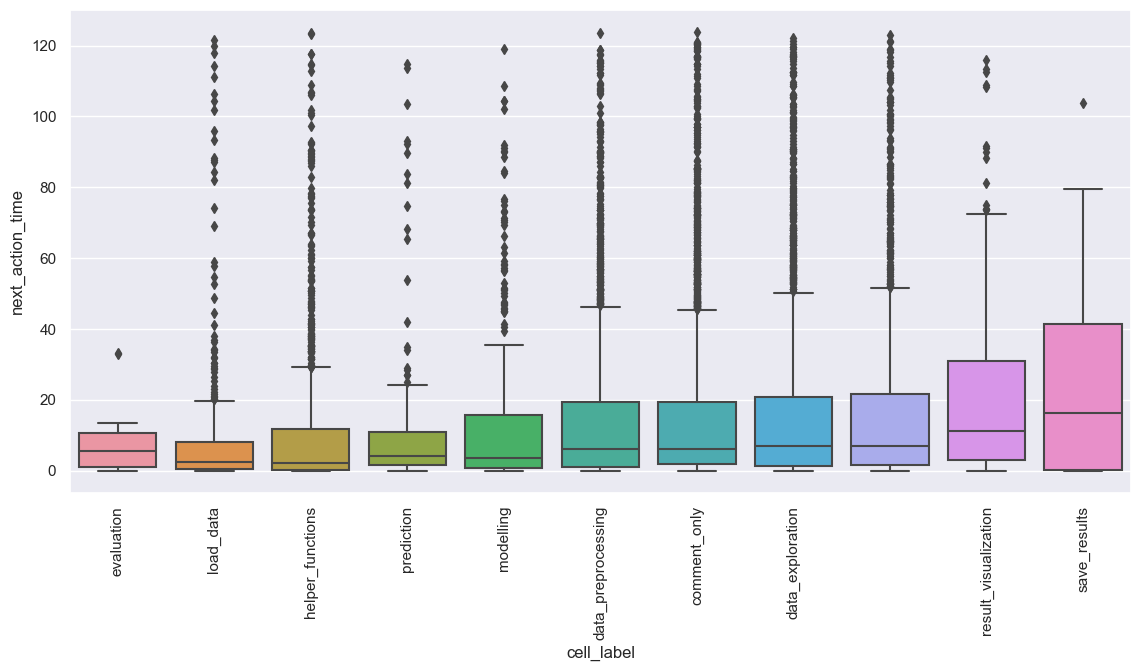

In [17]:
plot_box_time(at_df)

/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


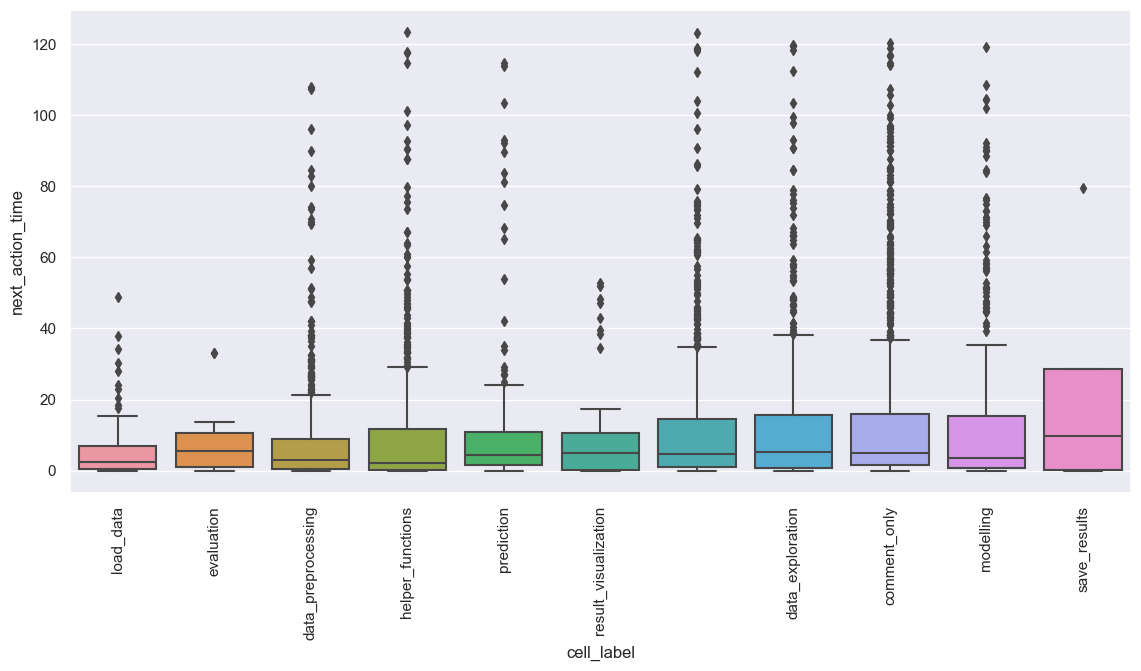

In [18]:
plot_box_time(at_df[at_df.task == 'task2'])

/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


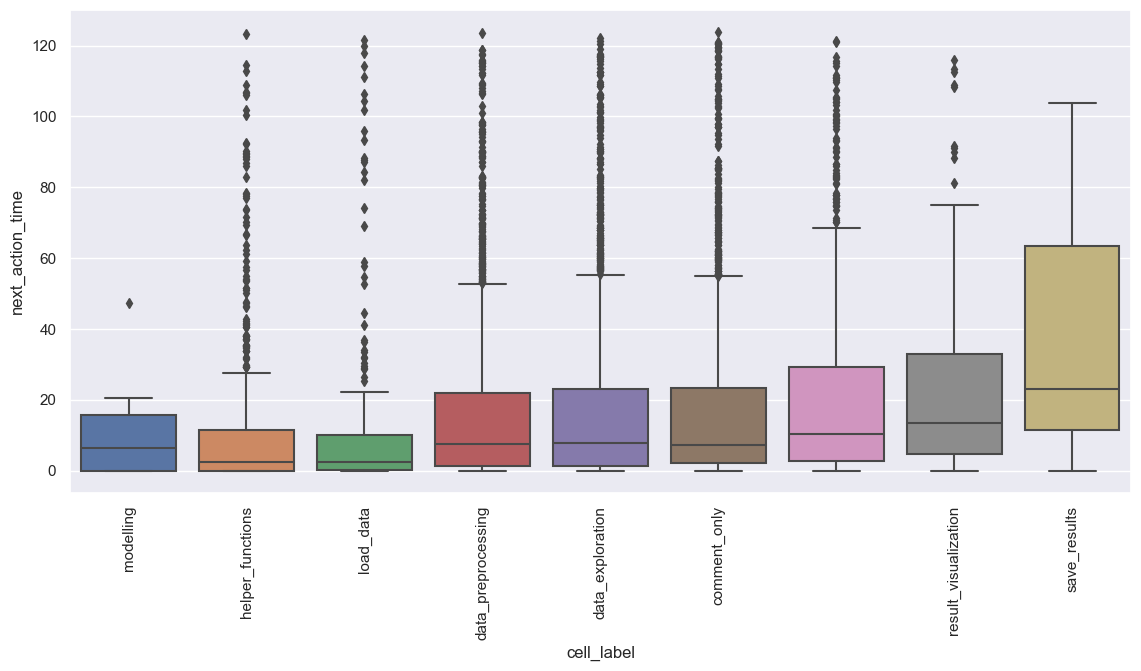

In [19]:
plot_box_time(at_df[at_df.task == 'task1'])

# Execution time

In [20]:
# TODO:
# deal with missing execs
# metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'state_time_dt']].state_time_dt.isna().sum()

In [21]:
metrics.loc[metrics.event == 'execute', 'cell_index'].nunique(), len(metrics[metrics.event == 'execute'])

(1963, 9207)

In [22]:
sum_exec = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'execution_time_sec'].sum()).to_frame('exec_time_sum') / 60
sum_exec_count = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'execution_time_sec'].count()).to_frame('exec_time_count')
sum_exec_mean = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'execution_time_sec'].mean()).to_frame('exec_time_mean') / 60
sum_all = metrics.groupby('kernel_id').next_action_time.sum().to_frame('overall_time') / 60

kernel_time_df = kernel_mapping.merge(sum_exec, on = 'kernel_id').merge(sum_exec_mean, on = 'kernel_id').merge(sum_all, on = 'kernel_id').merge(sum_exec_count, on = 'kernel_id')
kernel_time_df['percent'] = kernel_time_df.exec_time_sum / kernel_time_df.overall_time * 100
kernel_time_df['exec_time_n'] = kernel_time_df.exec_time_sum / kernel_time_df.exec_time_count
exec_comp = kernel_time_df.groupby(['task', 'expert']).describe()
exec_comp_task = kernel_time_df.groupby('task').describe()
exec_comp_exp = kernel_time_df.groupby('expert').describe()

cols = list(product(['exec_time_sum', 'percent','exec_time_n'],['mean', 'std']))
exec_stats = exec_comp.loc[:,cols]
exec_stats


exec_time_sum               percent            exec_time_n  \
                      mean        std       mean        std        mean   
task  expert                                                              
task1 False      15.491702  13.892578   7.604895   8.479777    0.046091   
      True        4.852870   4.124956   2.939032   2.575988    0.021221   
task2 False      28.608836  27.395937  11.896294   9.504634    0.124502   
      True       30.828633  38.964322  14.205822  13.352789    0.089659   

                        
                   std  
task  expert            
task1 False   0.024745  
      True    0.020112  
task2 False   0.077949  
      True    0.100282

In [24]:
test


action_id                                                      \
                 count          mean      min       25%      50%       75%   
task  expert                                                                 
task1 False    10141.0   7586.257272      1.0   2875.00   5773.0  10245.00   
      True      2747.0  20462.550783  16416.0  17210.50  21044.0  22448.50   
task2 False     3072.0  10405.959635   5796.0   8952.75  10597.0  12337.25   
      True      4888.0  16556.278642  13515.0  14842.75  16161.5  18325.50   

                                     time                                 ...  \
                  max          std  count                           mean  ...   
task  expert                                                              ...   
task1 False   23621.0  6374.876134  10141  2023-05-20 04:30:26.901863936  ...   
      True    23530.0  2372.888407   2747  2023-07-29 12:21:30.830714368  ...   
task2 False   13514.0  2187.036110   3072  2023-05-06 17:47:11.553999616  ...   
      True    19746.0  1917.520103   4888  2023-06-10 11:29:04.719499264  ...   

             execution_time_sec            next_action_time                    \
                            max        std            count       mean    min   
task  expert                                                                    
task1 False             377.723  15.808495           5718.0  42.983284  0.000   
      True              213.072   9.197641           1548.0  31.697414  0.000   
task2 False             860.864  50.742385           1717.0  42.879314  0.001   
      True              904.483  46.528965           2853.0  27.812308  0.000   

                                                               
                  25%    50%       75%        max         std  
task  expert                                                   
task1 False   1.46950  7.725  26.78825  12649.736  309.940488  
      True    2.48525  9.797  33.18100   1426.984   73.155112  
task2 False   1.65900  5.711  19.66900   9607.840  323.199584  
      True    0.74900  3.917  14.14500   4114.957  155.382600  

[4 rows x 64 columns]

In [25]:
# TODO: Refactor normal names
test = pd.concat([desc_stats_all.reset_index(), desc_stats_task.reset_index(), desc_stats_exp.reset_index()])
test2 = pd.concat([exec_comp.reset_index(), exec_comp_task.reset_index(), exec_comp_exp.reset_index()])
test = pd.concat([test, test2[[('percent', 'mean'), ('percent', 'std')]]], axis=1)

pretty_lang = {'task1': 'DS', 'task2': 'ML', np.NaN: 'All',
               False: 'Student', True: 'Professional'}
new_names = ['Task','Level of expertise', 'Execution time (sec)', 'Execution time (sec)', 'Time between actions (sec)', 'Time between actions (sec)', '% of total time', '% of total time']
test.columns =  pd.MultiIndex.from_tuples([(new_names[i] ,column[1]) for i, column in enumerate(test.columns.to_list())])
test = test.replace(pretty_lang).set_index(['Task', 'Level of expertise']).applymap(lambda x: str.format("{:0_.2f}", x).replace('.', ',').replace('_', '.'))
test = test.loc[test.index[[0,1,4,2,3,5,6,7]]]
print(test.to_latex(escape=True))

\begin{tabular}{llllllll}
\toprule
 &  & \multicolumn{2}{r}{Execution time (sec)} & \multicolumn{2}{r}{Time between actions (sec)} & \multicolumn{2}{r}{\% of total time} \\
 &  & mean & std & mean & std & mean & std \\
Task & Level of expertise &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{DS} & Student & 2,66 & 14,14 & 17,16 & 24,77 & 7,60 & 8,48 \\
 & Professional & 1,23 & 9,41 & 19,40 & 25,28 & 2,94 & 2,58 \\
 & All & 2,36 & 13,29 & 17,64 & 24,90 & 6,38 & 7,61 \\
\cline{1-8}
\multirow[t]{3}{*}{ML} & Student & 5,22 & 39,45 & 14,24 & 22,22 & 11,90 & 9,50 \\
 & Professional & 3,34 & 32,18 & 10,91 & 18,18 & 14,21 & 13,35 \\
 & All & 4,08 & 35,24 & 12,15 & 19,84 & 13,05 & 11,12 \\
\cline{1-8}
\multirow[t]{2}{*}{All} & Student & 3,26 & 22,76 & 16,48 & 24,24 & 8,89 & 8,78 \\
 & Professional & 2,57 & 26,26 & 13,86 & 21,31 & 9,08 & 11,24 \\
\cline{1-8}
\bottomrule
\end{tabular}


/var/folders/jq/byk1x73j6pngqgl6my8tgyhm0000gn/T/ipykernel_97982/2950516028.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test = test.replace(pretty_lang).set_index(['Task', 'Level of expertise']).applymap(lambda x: str.format("{:0_.2f}", x).replace('.', ',').replace('_', '.'))


In [26]:
execs = metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'execution_time_sec']].dropna()

In [27]:
execs.anova(dv="execution_time_sec", between=["expert", "task"]).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,expert,6539.547,1.0,6539.547,6.476,0.011,0.001
1,task,36139.237,1.0,36139.237,35.787,0.000,0.004
2,expert * task,80.944,1.0,80.944,0.080,0.777,0.000
3,Residual,9063344.666,8975.0,1009.843,NaN,NaN,NaN


In [28]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_count']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_count']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.46,16.83,two-sided,0.16,"[-33.81, 185.78]",0.51,0.868,0.15


In [29]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_n']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_n']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.23,8.71,two-sided,0.05,"[-0.0, 0.05]",1.05,1.996,0.48


In [30]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task2')), 'exec_time_n']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task2')), 'exec_time_n']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.67,10,two-sided,0.52,"[-0.08, 0.15]",0.39,0.54,0.09


In [31]:
pd.concat([desc_stats, exec_stats['percent']], axis=1)

NameError: name 'desc_stats' is not defined

In [32]:
for column in exec_stats['percent'].columns:
    desc_stats[('percent',column)] = exec_stats[('percent', column)]

NameError: name 'desc_stats' is not defined

In [33]:
desc_stats

NameError: name 'desc_stats' is not defined

In [34]:
pd.merge(desc_stats.reset_index(), exec_stats['percent'].reset_index(), on = ['task', 'expert'])

NameError: name 'desc_stats' is not defined

In [35]:
# TODO: check difference in exec time 
metrics.groupby('labels').execution_time_sec.describe().sort_values(by='mean')

KeyError: 'labels'

/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


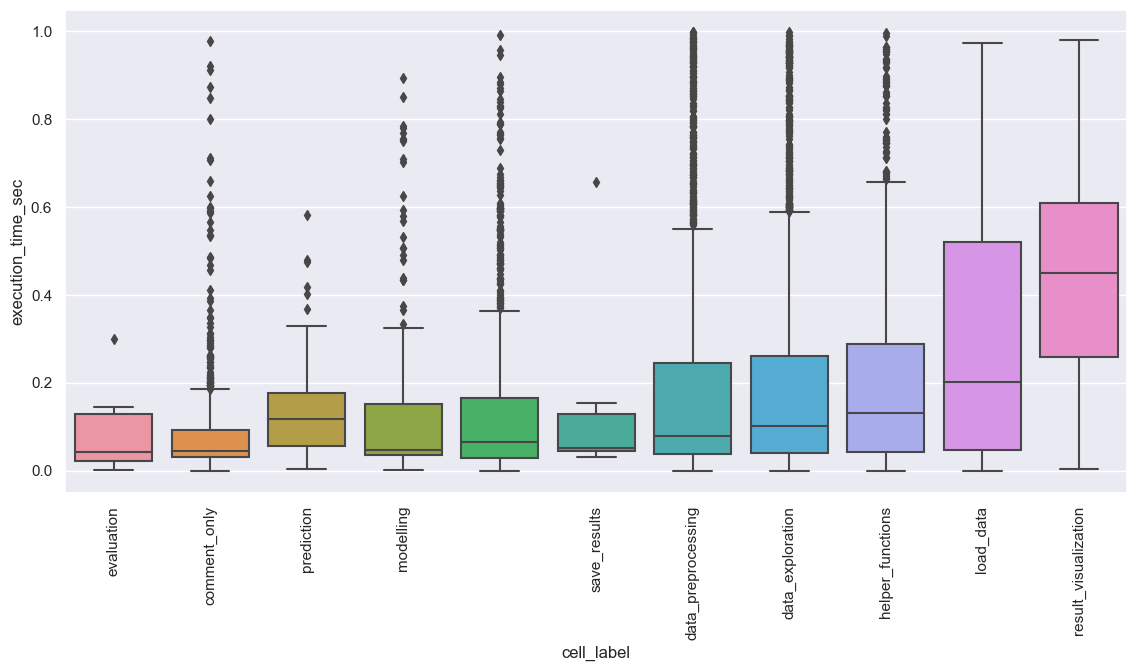

In [36]:
plot_box_time(metrics[metrics.execution_time_sec < 1], var='execution_time_sec')

/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


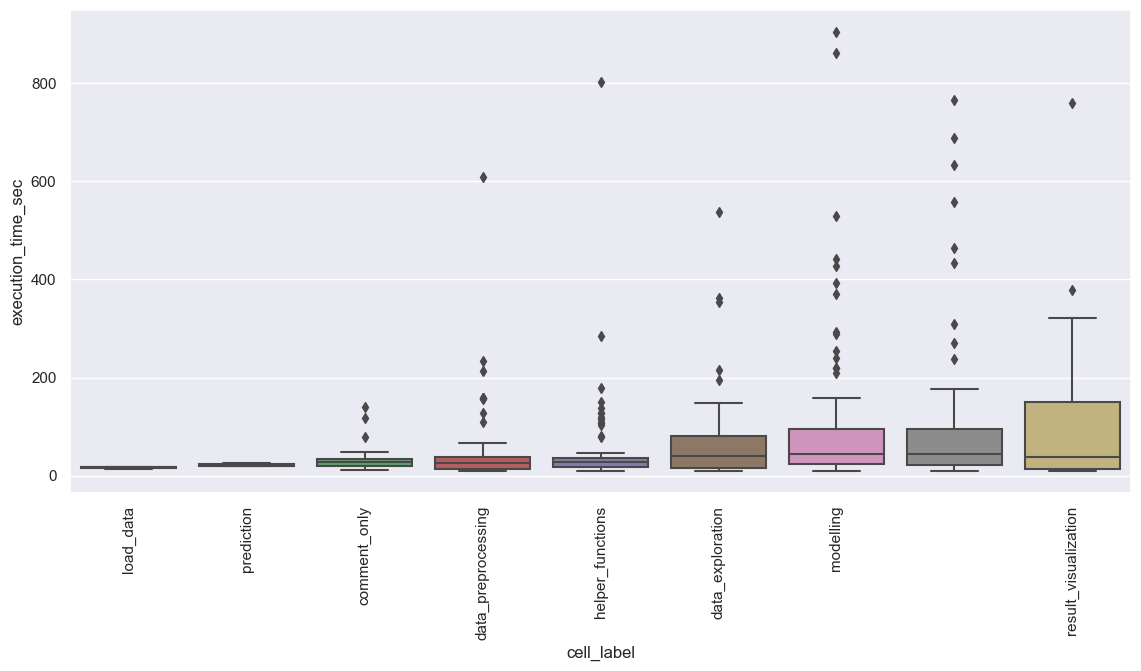

In [37]:
plot_box_time(metrics[metrics.execution_time_sec > 10], var='execution_time_sec')

In [38]:
metrics['scr_len'] = metrics.cell_source.str.len()

/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/konstantingrotov/Library/Caches/pypoetry/virtualenvs/jupyter-logging-backend-FOYMgaQR-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_c

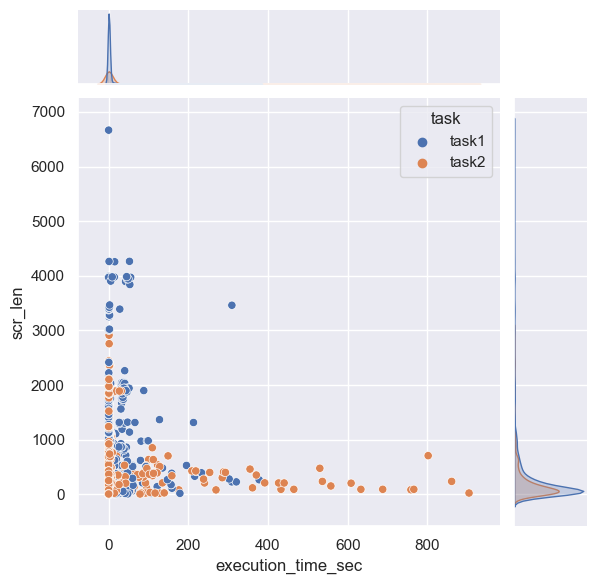

In [39]:
sns.jointplot(metrics[metrics.event == 'execute'], x='execution_time_sec', y='scr_len', hue='task');

In [40]:
pg.corr(metrics[metrics.event == 'execute'].execution_time_sec, metrics[metrics.event == 'execute'].scr_len)

,n,r,CI95%,p-val,BF10,power
pearson,8978,0.058308,"[0.04, 0.08]",3.224604e-08,5.728e+04,0.999822


In [41]:
# plot_box_time(metrics[metrics.execution_time_sec < 10], var='execution_time_sec')

# Interruptions

In [42]:
metrics

,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,...,cell_label,task,execution_time,execution_start,result,interruptions,src_len,execution_time_sec,next_action_time,scr_len
0,1113,2023-05-06 11:58:35.270,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,helper_functions,task1,0 days 00:00:22.731000,2023-05-06 11:58:35.270,stream,0,162.0,22.731,27.383,162.0
1,1114,2023-05-06 11:58:58.001,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,helper_functions,task1,NaT,NaT,NaN,0,162.0,NaN,NaN,162.0
2,1116,2023-05-06 11:59:02.653,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,a47800e62cbe40c1ad4003b2879f5f03,1.0,code,!pip install pandas\n,...,helper_functions,task1,0 days 00:00:00.822000,2023-05-06 11:59:02.653,stream,0,20.0,0.822,2.610,20.0
3,1117,2023-05-06 11:59:03.475,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,a47800e62cbe40c1ad4003b2879f5f03,2.0,code,!pip install pandas\n,...,helper_functions,task1,NaT,NaT,NaN,0,20.0,NaN,NaN,20.0
4,1118,2023-05-06 11:59:05.263,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,code,!pip install sklearn,...,helper_functions,task1,0 days 00:00:00.755000,2023-05-06 11:59:05.263,stream,0,20.0,0.755,2.303,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20843,19742,2023-07-03 15:49:31.530,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,create,6e3d3614064748888cc82a221f924fd4,75.0,code,None,...,comment_only,task2,NaT,NaT,NaN,0,NaN,NaN,2.149,NaN
20844,19743,2023-07-03 15:49:33.679,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,execute,6e3d3614064748888cc82a221f924fd4,76.0,code,y_pred,...,evaluation,task2,0 days 00:00:00.144000,2023-07-03 15:49:33.679,execute_result,1,6.0,0.144,0.034,6.0
20845,19744,2023-07-03 15:49:33.713,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,create,30506d3f2fce44f18584f719e752d811,76.0,code,None,...,comment_only,task2,NaT,NaT,NaN,0,NaN,NaN,3.047,NaN
20846,19745,2023-07-03 15:49:33.823,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,finished_execute,6e3d3614064748888cc82a221f924fd4,77.0,code,y_pred,...,evaluation,task2,NaT,NaT,NaN,0,6.0,NaN,NaN,6.0


In [43]:
test = metrics[metrics.labels.apply(lambda x: len(x.strip().split(',')) - 1 if isinstance(x, str) else None) == 1]

AttributeError: 'DataFrame' object has no attribute 'labels'

In [44]:
sns.jointplot(test[(test.labels != 'helper_functions,')& (test.interruptions > 0)], x='execution_time_sec', y='interruptions', hue='task');

AttributeError: 'DataFrame' object has no attribute 'labels'

In [45]:
test_plot = test[(test.interruptions > 0)]
sns.boxplot(test[(test.labels != 'helper_functions,')& (test.interruptions > 0)], x='labels', y='interruptions')

AttributeError: 'DataFrame' object has no attribute 'interruptions'

In [46]:
kernel_time_df

,kernel_id,task,expert,exec_time_sum,exec_time_mean,overall_time,exec_time_count,percent,exec_time_n
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1,False,2.400483,0.013262,144.041617,181,1.666521,0.013262
1,033a2c63-4cfb-4cc5-9988-59c48a06eb23,task1,False,6.741050,0.019096,223.492867,353,3.016226,0.019096
2,19160d7e-eb8e-4a81-9e92-e9d8335eee31,task1,True,1.903200,0.008852,151.073600,215,1.259783,0.008852
3,232bcb48-7455-4109-9eeb-809649a6bedc,task2,True,20.449583,0.045646,279.871267,448,7.306782,0.045646
4,29da7c56-5a69-485f-b181-a0a7199a559c,task1,False,37.145933,0.098792,213.735483,376,17.379395,0.098792
5,2bc4e2c9-833e-454f-8c6c-2dff1e6e60e9,task2,False,14.169717,0.208378,241.559917,68,5.865922,0.208378
6,2d945a8d-90c3-40a6-a576-f1b7cf5d6790,task1,True,9.732650,0.031910,182.015917,305,5.347142,0.031910
7,3179a989-9b41-49b9-84f8-5fe83a7c65bf,task2,True,103.703967,0.278774,295.009800,372,35.152719,0.278774
8,36c724d9-3a5f-43e2-aba2-2d0933046f35,task1,False,27.723733,0.067291,537.872283,412,5.154334,0.067291
9,388ef554-e3e7-4410-89ac-d6ad4aeaec6c,task2,False,2.866833,0.012856,134.999850,223,2.123583,0.012856
